In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from itertools import combinations
import seaborn as sns
import sys
from utils.config import get_config

from src.matrix_operations import degree_centrality



config = get_config()
sys.path.insert(0, config["neuroginius"])

from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_stat_map

from src.stats import nonparametric_p_value, signed_stouffer

atlas = Atlas().from_name("schaefer200")
classes = ["stable", "declining"]

Text(0.5, 1.0, 'Haufe patterns')

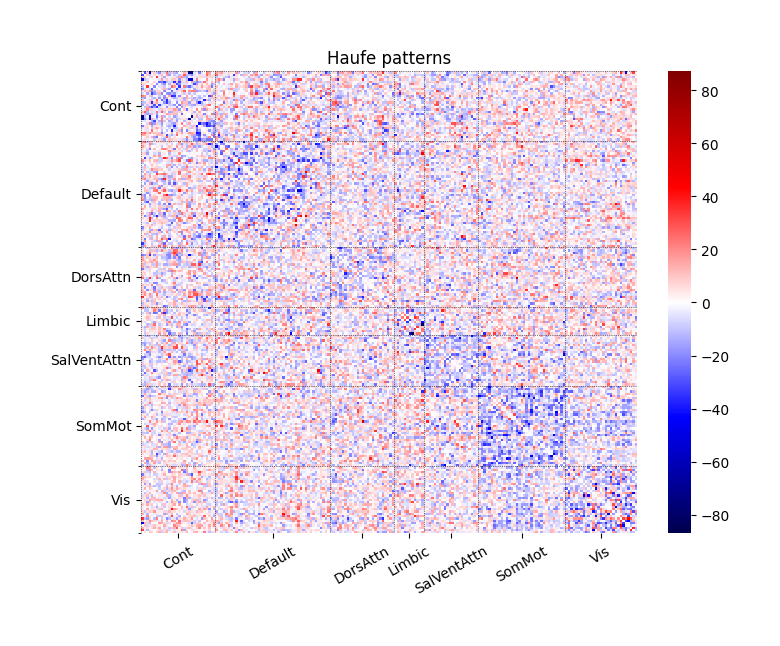

In [2]:
data_dir = Path(config["data_dir"])
n_perm = 1000
mat_file = data_dir / f"{n_perm}perm_mean_tangent_patterns.joblib"
perm_mat_file = data_dir / f"{n_perm}perm_mean_tangent_perm_patterns.joblib"

with open(mat_file, 'rb') as f:
    haufe_matrices = joblib.load(f)

with open(perm_mat_file, 'rb') as f:
    perm_haufe_matrices = joblib.load(f)
    
haufe_matrices = haufe_matrices.squeeze()
plot_matrix(haufe_matrices, atlas)
plt.title("Haufe patterns")

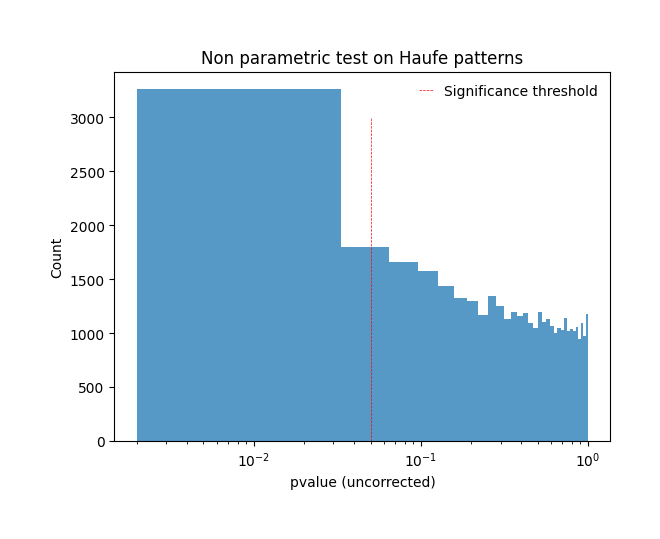

In [3]:
p_values = nonparametric_p_value(haufe_matrices, perm_haufe_matrices).squeeze()
sns.histplot(p_values.ravel())
plt.xscale('log')
plt.vlines(0.05, 0, 3000, color='red', linestyle='--', label="Significance threshold")
plt.title("Non parametric test on Haufe patterns")
plt.xlabel("pvalue (uncorrected)")
plt.legend(loc="upper right")
plt.show()

In [4]:
from matplotlib.ticker import FixedLocator        

def set_network_ticks(axes, atlas):
    networks = np.array(atlas.macro_labels)
    sort_index = np.argsort(networks)
    n_regions = len(networks)
    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            ticks.append(i)
            lbls.append(label)
            prev_label = label
            axes.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
            axes.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

    ticks.append(i + 1)

    axes.yaxis.set_minor_locator(FixedLocator(ticks))
    axes.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    axes.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    axes.set_yticklabels(lbls, rotation=0, fontsize=12)
    axes.set_xticklabels(lbls, rotation=30, fontsize=12)

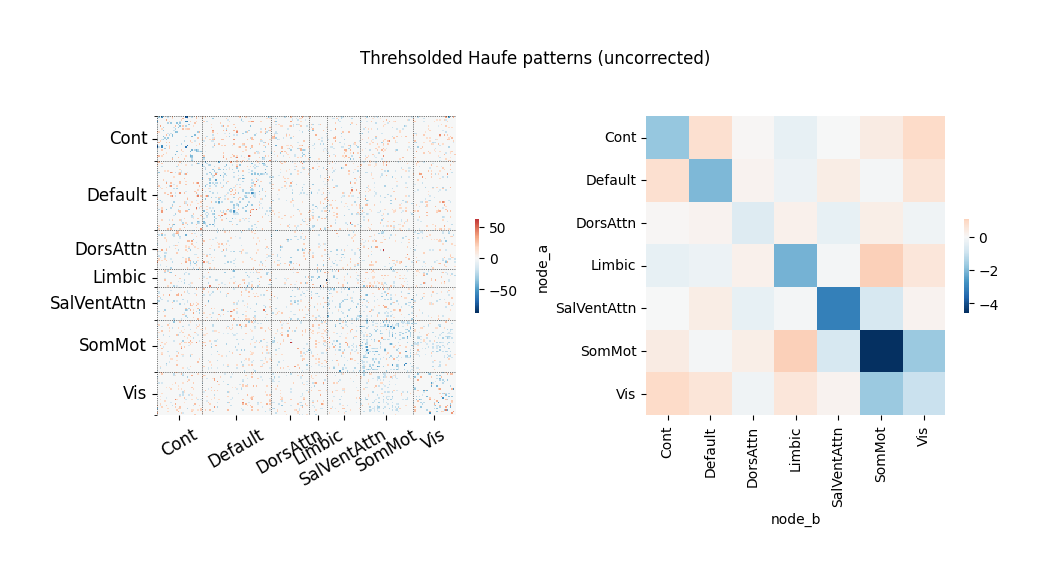

In [5]:
from neuroginius.matrices import MatrixResult

thresholded_mat = np.where(p_values < 0.05, haufe_matrices, 0)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 10))
sns.heatmap(MatrixResult(thresholded_mat, atlas=atlas).sorted_matrix, square=True, 
            center=0,
            cmap='RdBu_r', ax=ax1, cbar_kws={'shrink': 0.1})
set_network_ticks(ax1, atlas)
sns.heatmap(MatrixResult(thresholded_mat, atlas=atlas).get_macro_matrix(), square=True, 
            center=0,
            cmap='RdBu_r', ax=ax2, cbar_kws={'shrink': 0.1})

plt.suptitle("Threhsolded Haufe patterns (uncorrected)", y=0.7)
plt.tight_layout()



In [6]:
def multivariate_blocks(block):
    return (block,)

In [7]:
unique_RSN_labels = np.unique(atlas.macro_labels)
mapping = {unique_RSN_labels[i]: i for i in range(len(unique_RSN_labels))}
RSN_labels_int = pd.Series(atlas.macro_labels).map(mapping).values

Calculating combined p-values
zscore: -3.67,avg difference: -3.32, pvalue: 0.0002
zscore: 4.51,avg difference: 1.18, pvalue: 0.0000
zscore: 1.45,avg difference: 0.39, pvalue: 0.1470
zscore: -1.04,avg difference: -0.65, pvalue: 0.2970
zscore: -2.04,avg difference: -0.59, pvalue: 0.0410
zscore: 5.48,avg difference: 1.39, pvalue: 0.0000
zscore: 8.73,avg difference: 2.44, pvalue: 0.0000
zscore: -12.27,avg difference: -3.49, pvalue: 0.0000
zscore: 1.08,avg difference: 0.23, pvalue: 0.2779
zscore: -2.21,avg difference: -0.82, pvalue: 0.0273
zscore: 0.20,avg difference: 0.10, pvalue: 0.8384
zscore: 1.57,avg difference: 0.27, pvalue: 0.1174
zscore: 4.27,avg difference: 1.14, pvalue: 0.0000
zscore: -1.36,avg difference: -2.08, pvalue: 0.1735
zscore: 0.46,avg difference: 0.12, pvalue: 0.6435
zscore: 1.65,avg difference: 0.67, pvalue: 0.0989
zscore: 2.54,avg difference: 0.70, pvalue: 0.0110
zscore: 1.80,avg difference: 0.58, pvalue: 0.0712
zscore: 2.43,avg difference: -1.28, pvalue: 0.0149
zscore

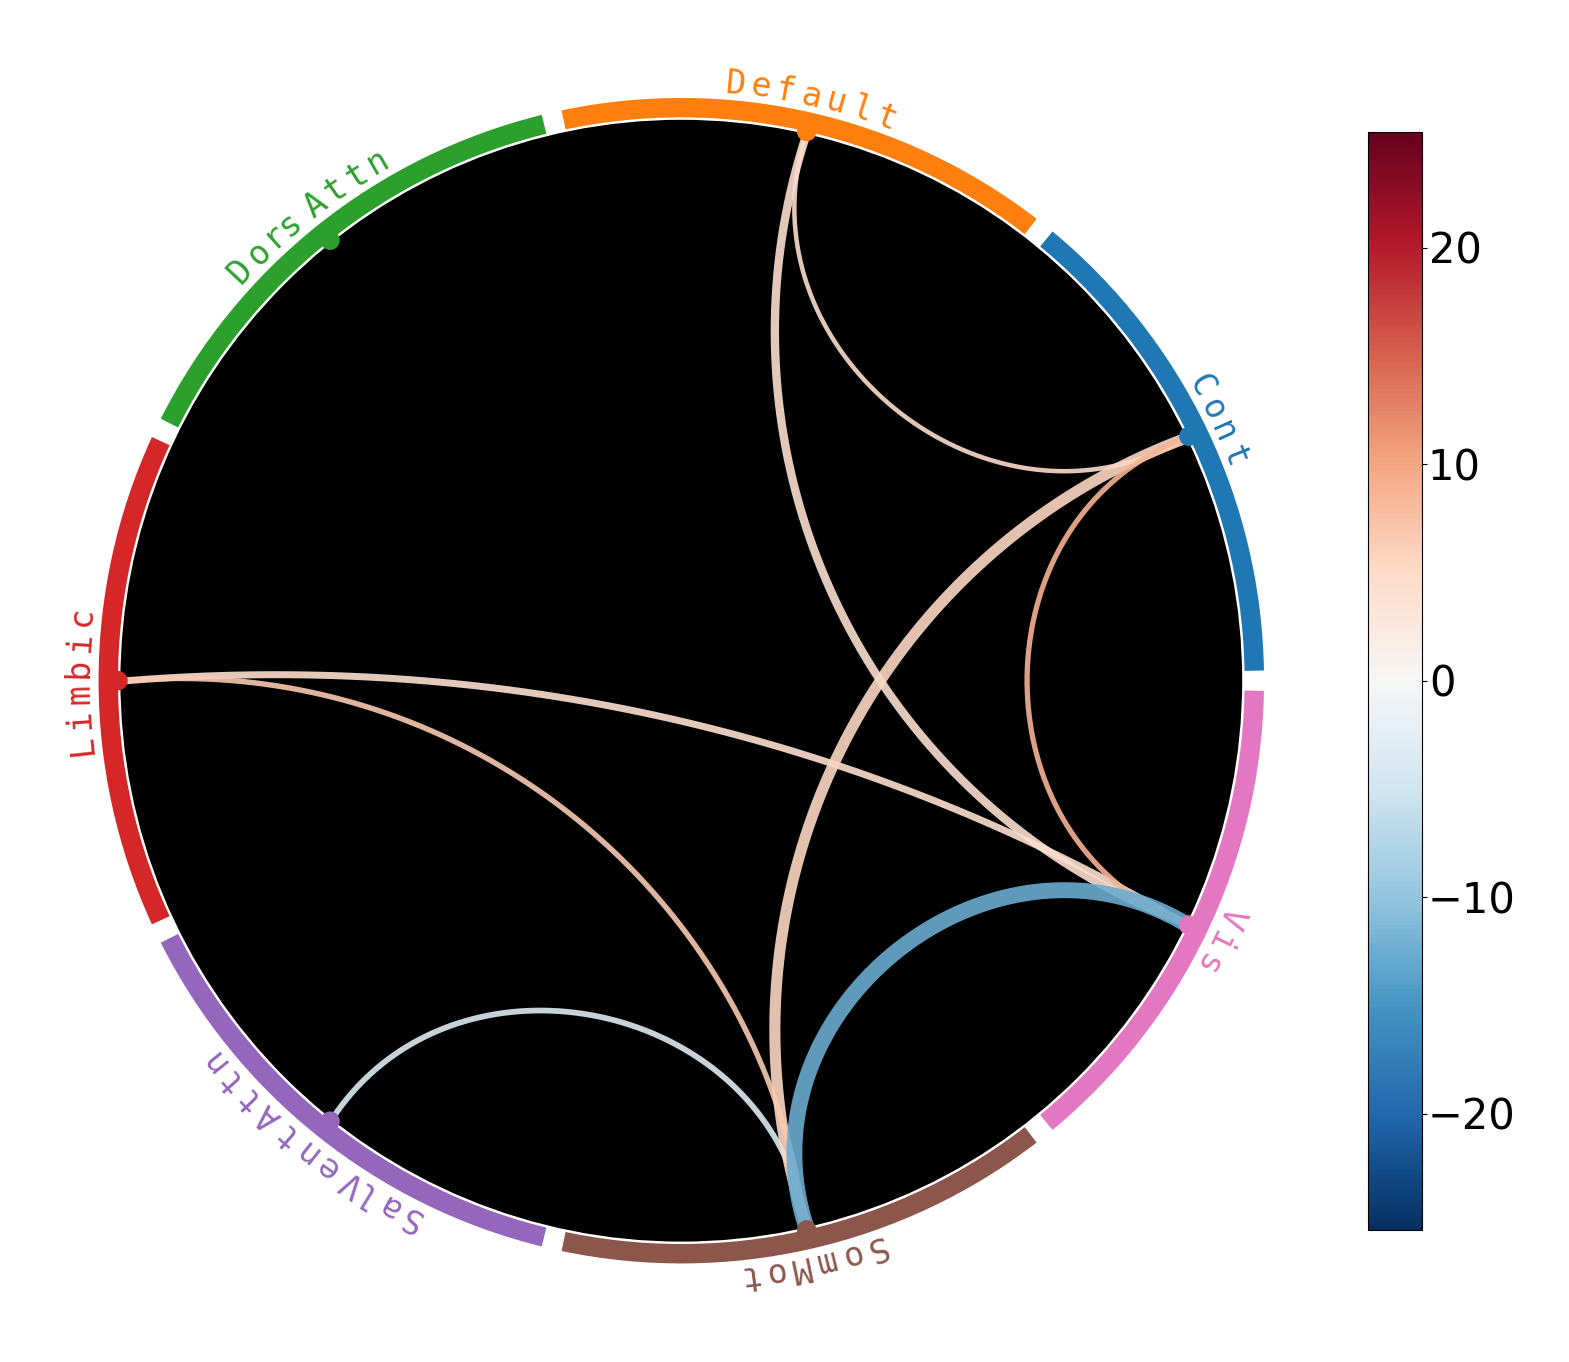

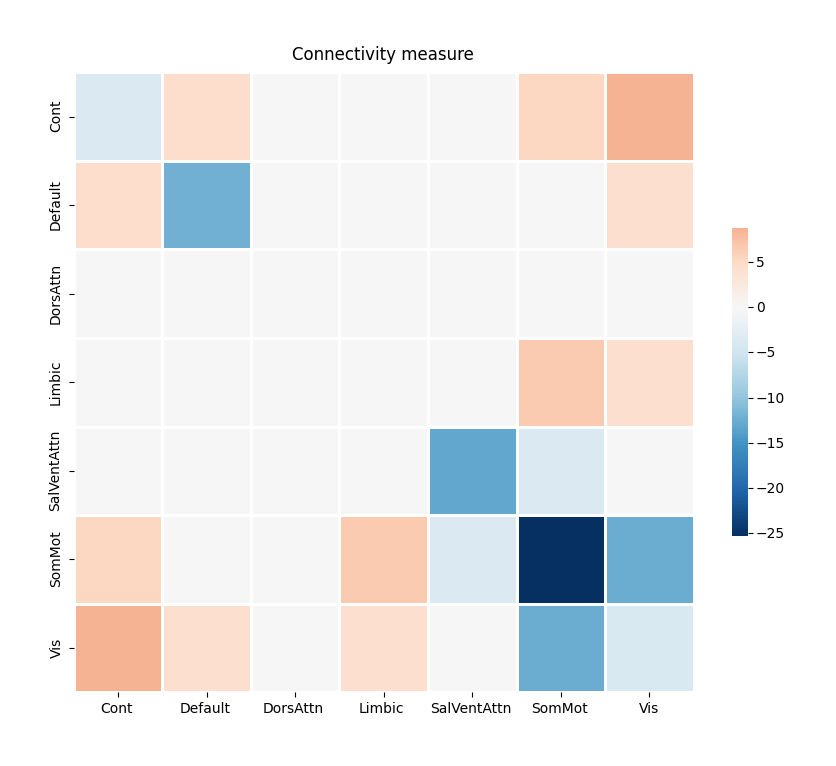

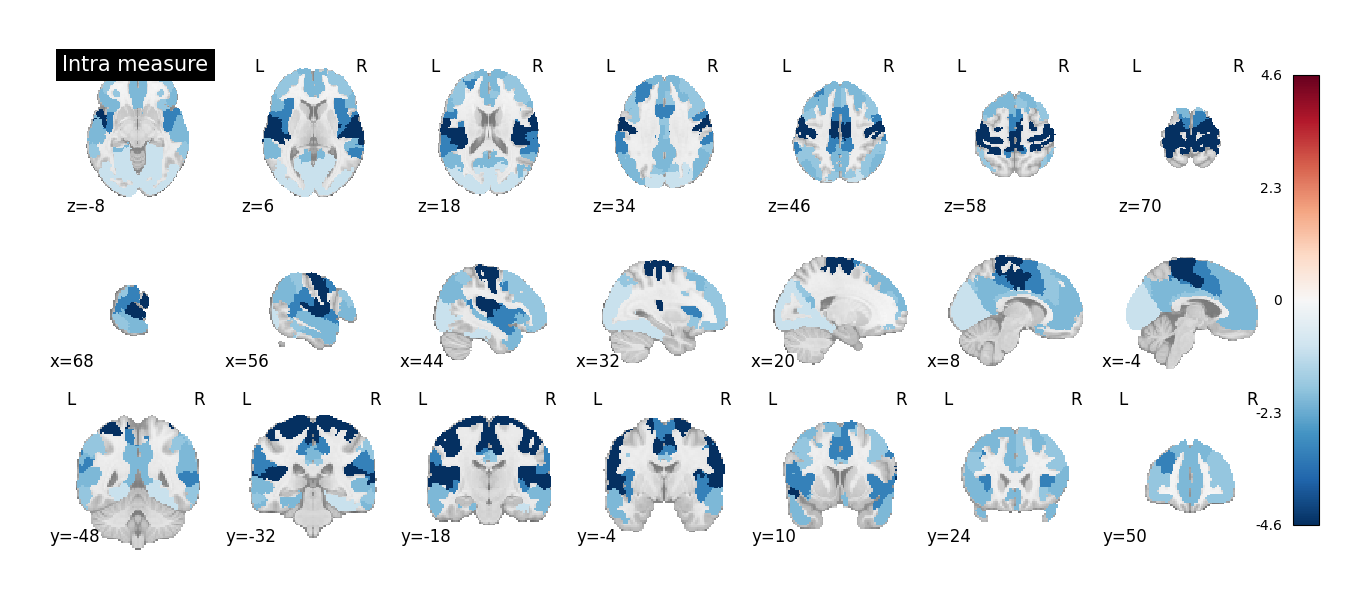

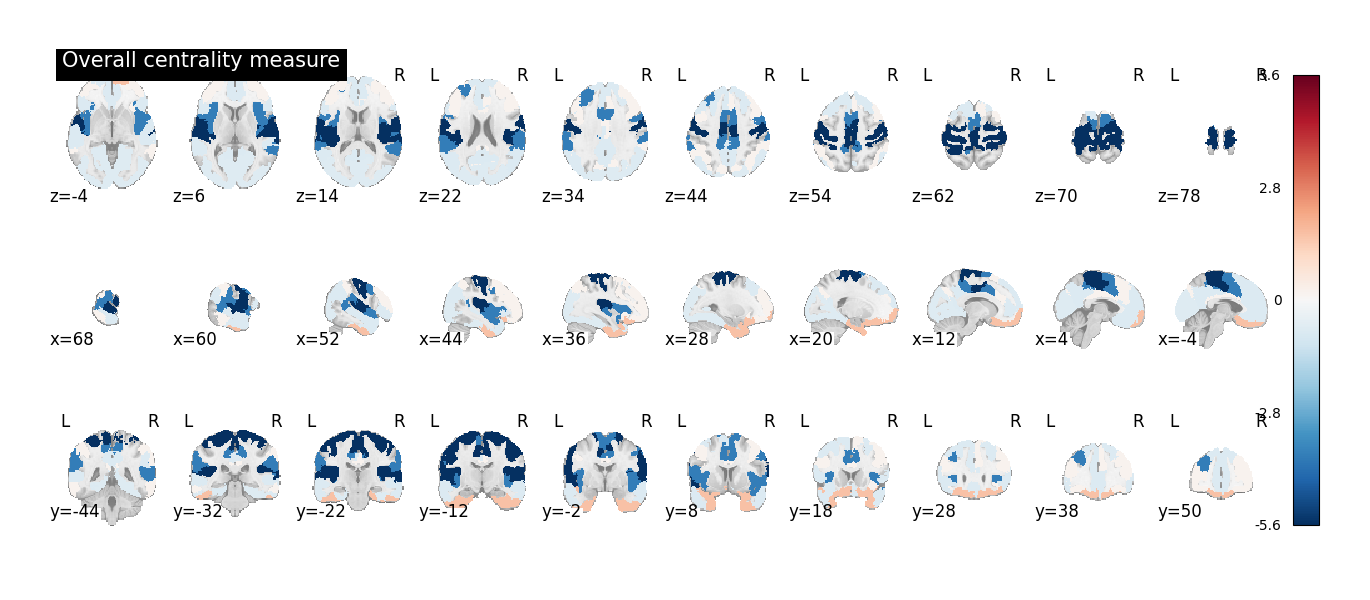

In [8]:
import numpy as np
# from pycct import cct
from scipy.stats import combine_pvalues
from itertools import combinations_with_replacement
from statsmodels.stats.multitest import multipletests, fdrcorrection

from src.matrix_operations import to_matrix
from src.plotting import plot_chord, matrix_to_chord


masker = NiftiLabelsMasker(labels_img=atlas.maps)
masker.fit()
RSNs = np.unique(atlas.macro_labels)

blocks = list(combinations_with_replacement(RSNs, 2))
network_labels = atlas.macro_labels

print(f"Calculating combined p-values")

blocked_pvalues = MatrixResult(p_values, atlas).get_macro_matrix(agg_func=multivariate_blocks)
blocked_matrices = MatrixResult(haufe_matrices, atlas).get_macro_matrix(agg_func=multivariate_blocks)

results = pd.DataFrame(index=RSNs, columns=RSNs, dtype=float)
tmp_results = []
zstat = []
for block_a, block_b in blocks:

    pvalues = blocked_pvalues.loc[block_a, block_b].copy().ravel()
    differences = blocked_matrices.loc[block_a, block_b].copy().ravel()

    # result = cct(pvalues)
    # result = combine_pvalues(pvalues, method='fisher', weights=weights)
    result = signed_stouffer(pvalues, differences)
    pvalue = result.pvalue
    tmp_results.append(pvalue)
    stat = result.statistic
    zstat.append(stat)
    print(f"zscore: {stat:.2f},avg difference: {differences.mean():.2f}, pvalue: {pvalue:.4f}")

# correction for multiple comparisons
pvalues_cor = multipletests(tmp_results, method='holm')[1]

for block_idx, (block_a, block_b) in enumerate(blocks):
    results.loc[block_a, block_b] = pvalues_cor[block_idx]
    results.loc[block_b, block_a] = pvalues_cor[block_idx]

significance_mask = np.where(results.values < 0.05, True, False)

block_thresholded_differences = MatrixResult(thresholded_mat, atlas=atlas).get_macro_matrix(lambda block: (block.mean(),))
block_thresholded_differences = block_thresholded_differences.where(significance_mask, 0)


result_to_plot = pd.DataFrame(to_matrix(zstat), 
                                index=RSNs, 
                                columns=RSNs)
result_to_plot = result_to_plot.where(significance_mask, 0)

matrix_to_chord(result_to_plot.values, atlas, percentile=None,
            diverging=True,
            positive_only=False,)


intra_results_vec = np.zeros(len(network_labels))
for idx, label in enumerate(network_labels):
    intra_results_vec[idx] = block_thresholded_differences.loc[label, label]

result_to_plot = pd.DataFrame(to_matrix(zstat), 
                                index=RSNs, 
                                columns=RSNs)
result_to_plot = result_to_plot.where(significance_mask, 0)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(result_to_plot, center=0, cmap='RdBu_r', cbar_kws={'shrink': 0.4}, annot=False,
            linewidths=0.8,
            square=True)
ax.set_title(f"Connectivity measure")
plt.show()

intra_projected_results = masker.inverse_transform(intra_results_vec)

plot_stat_map(intra_projected_results, display_mode='mosaic', cmap='RdBu_r', 
                title=f"Intra measure", symmetric_cbar=True)

plt.show()

pos_centrality, neg_centrality = degree_centrality(block_thresholded_differences, weighted=True)
pos_results_vec = np.zeros(len(atlas.macro_labels))
neg_results_vec = np.zeros(len(atlas.macro_labels))
for idx, label in enumerate(RSN_labels_int):
    pos_results_vec[idx] = pos_centrality[label]
    neg_results_vec[idx] = neg_centrality[label]



overall_centrality = pos_results_vec + neg_results_vec

overall_centrality_results = masker.inverse_transform(overall_centrality)

plot_stat_map(overall_centrality_results,
    cmap='RdBu_r',
    display_mode='mosaic',
    cut_coords=10, 
    title=f"Overall centrality measure", symmetric_cbar=True)
overall_centrality_results.to_filename(f"tmp_overall_centrality_RSNlevel.nii.gz")
plt.show()

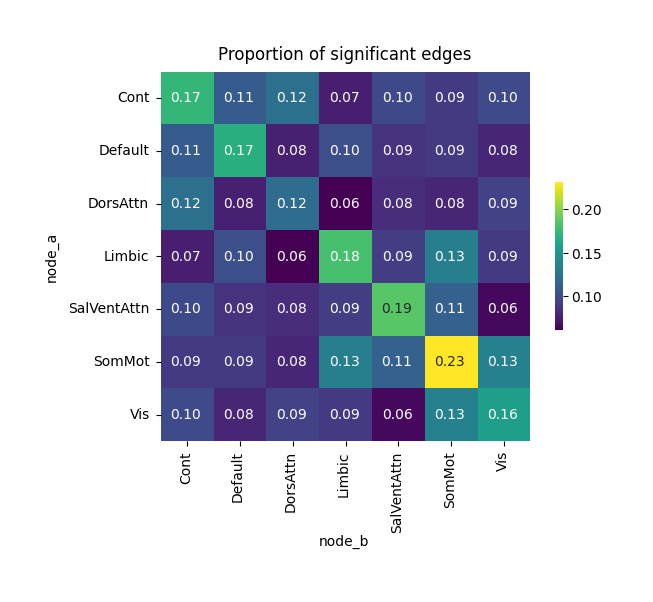

In [9]:
def count_significant(block):
    threshold = 0.05
    return (np.count_nonzero(block < threshold) / block.size,)

pippo = MatrixResult(p_values, atlas=atlas).get_macro_matrix(agg_func=count_significant)
sns.heatmap(pippo, cmap='viridis', annot=True, fmt=".2f", square=True, cbar_kws={'shrink': 0.4})
plt.title("Proportion of significant edges")
plt.show()

In [10]:
def extract_anatomical_label(label):
    region_tags = str(label).split("_")
    if len(region_tags) == 4:
        return region_tags[2]
    return region_tags[3] + f" ({region_tags[2]})"


anatomical_labels = tuple(map(extract_anatomical_label, atlas.labels))

In [11]:
unique_labels = np.unique(anatomical_labels)
mapping = {unique_labels[i]: i for i in range(len(unique_labels))}
anatomical_labels_int = pd.Series(anatomical_labels).map(mapping).values

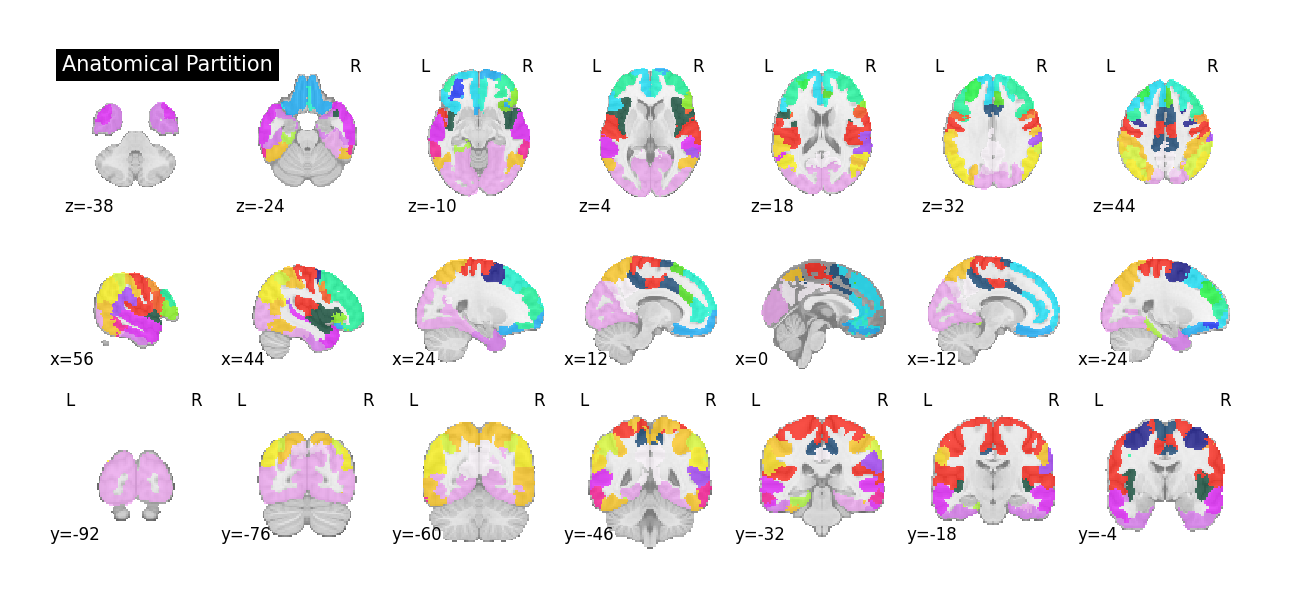

In [12]:
anatomical_atlas_map = masker.inverse_transform(anatomical_labels_int.astype(np.int32))

from nilearn.plotting import plot_roi
plot_roi(anatomical_atlas_map, title="Anatomical Partition", display_mode='mosaic')

In [13]:
class NiftiImageAtlas:
    def __init__(self, nifti_image, macro_labels=None):
        self.nifti_image = nifti_image
        self.labels = np.unique(nifti_image.get_fdata())
        if macro_labels is not None:
            self.macro_labels = macro_labels
        else:
            self.macro_labels = np.unique(self.labels)
        self.maps = nifti_image

    @classmethod
    def from_path(cls, path):
        from nilearn.image import load_img
        return cls(load_img(path))
    
anatomical_atlas = NiftiImageAtlas(anatomical_atlas_map, macro_labels=anatomical_labels)

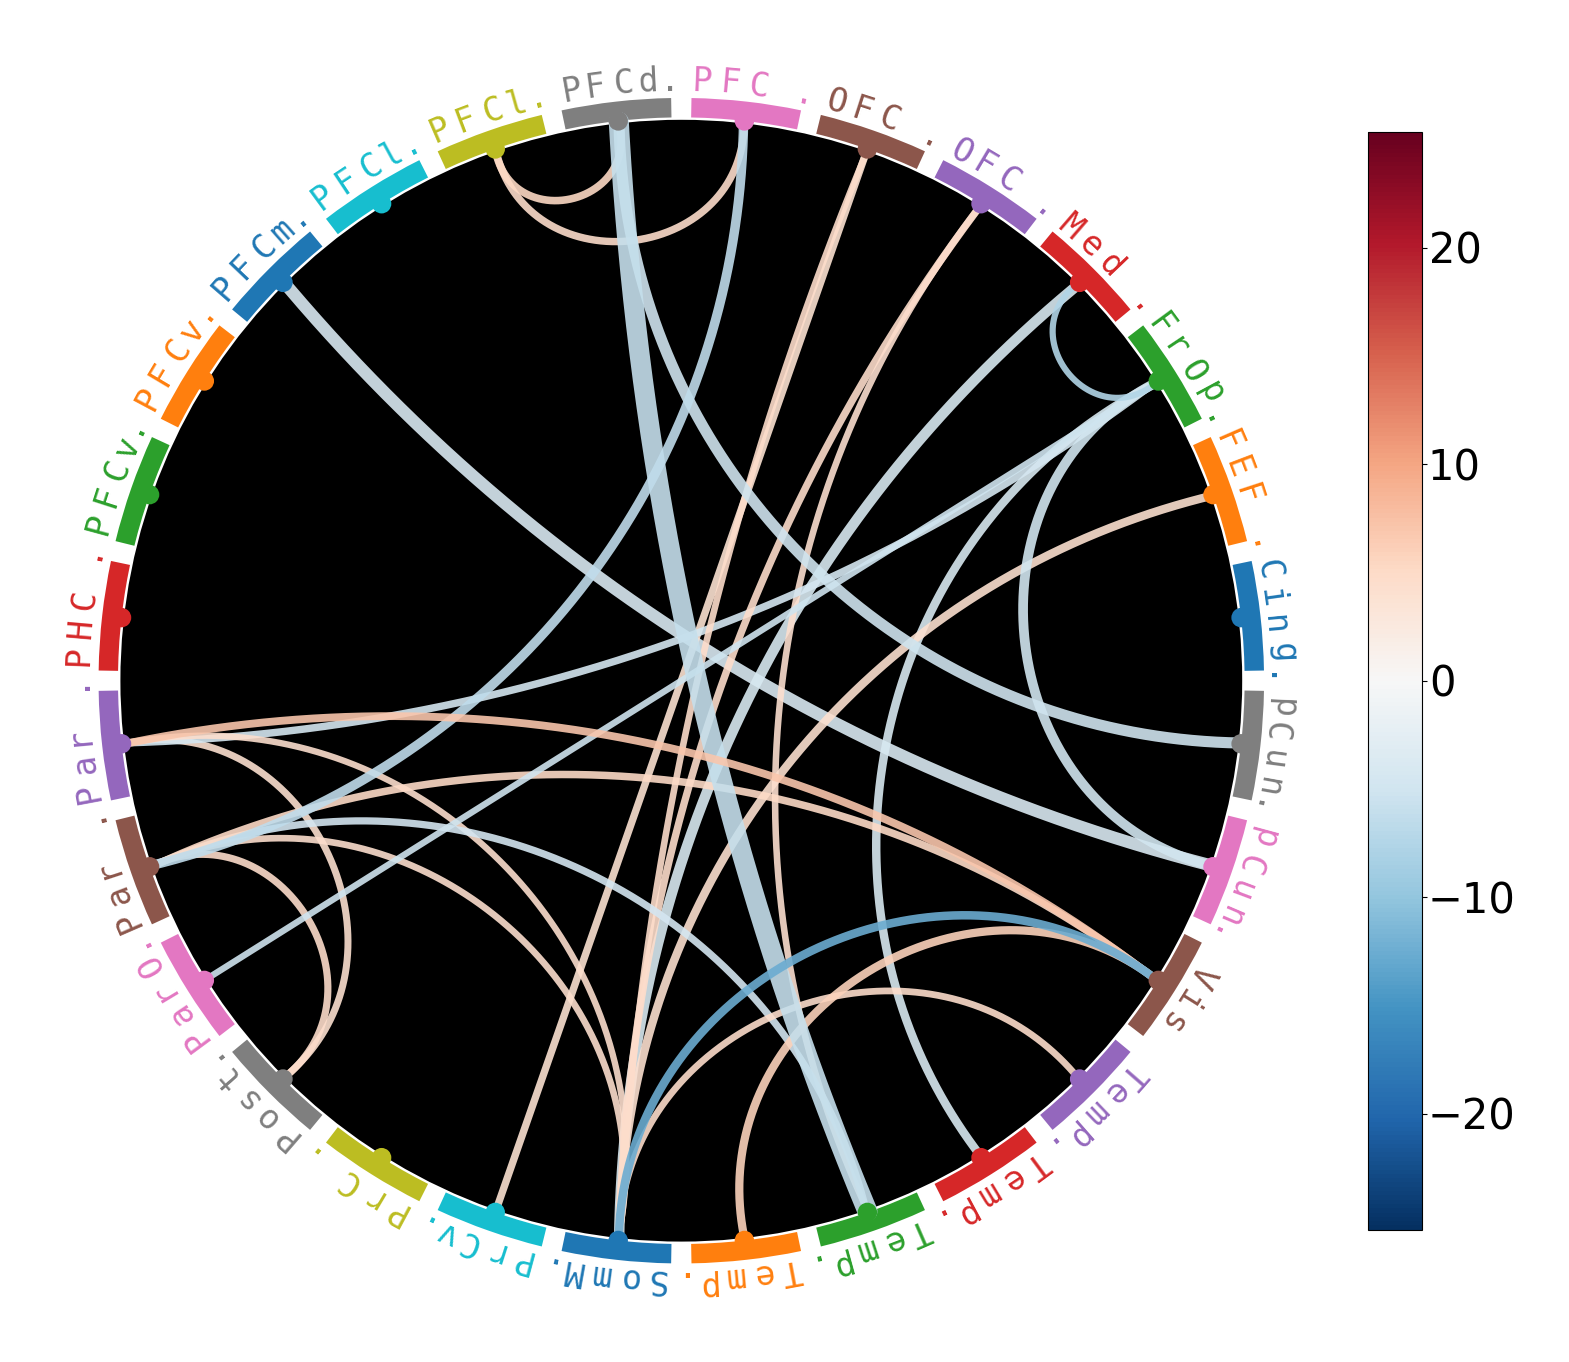

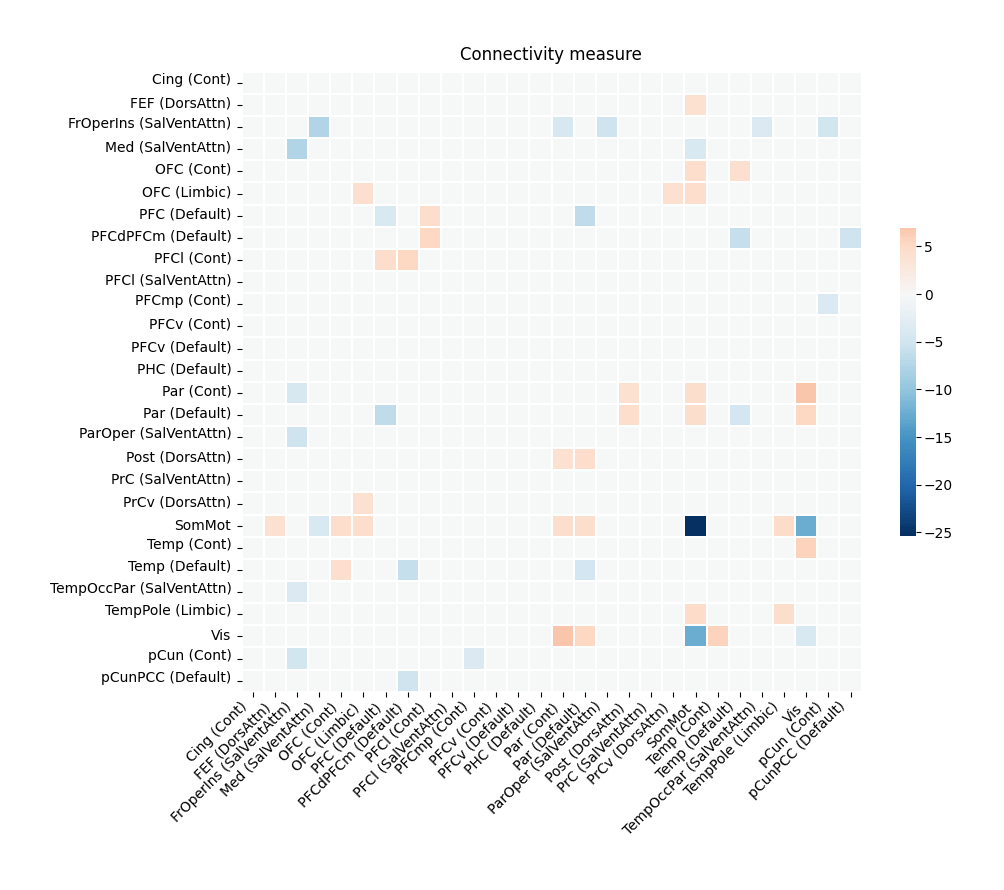

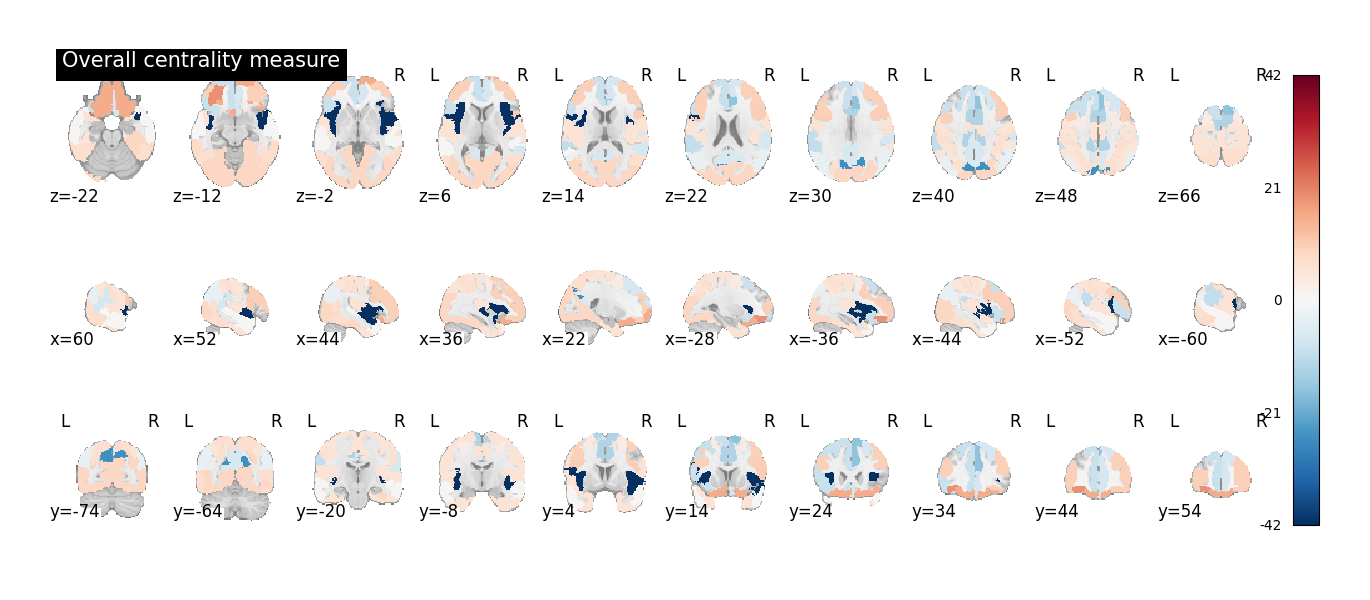

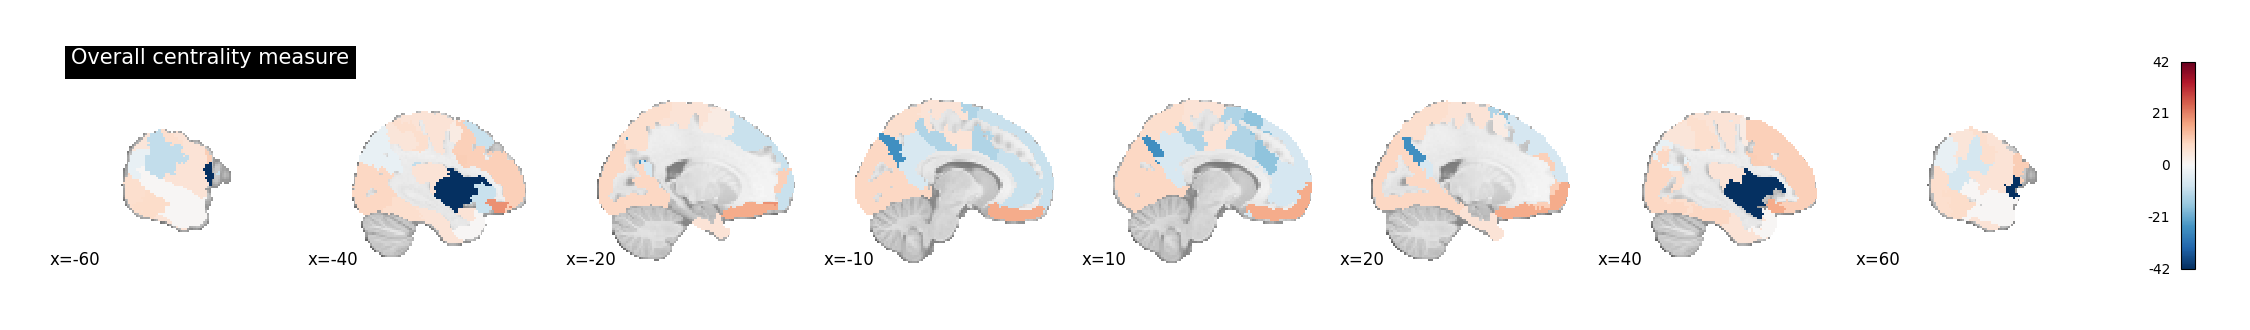

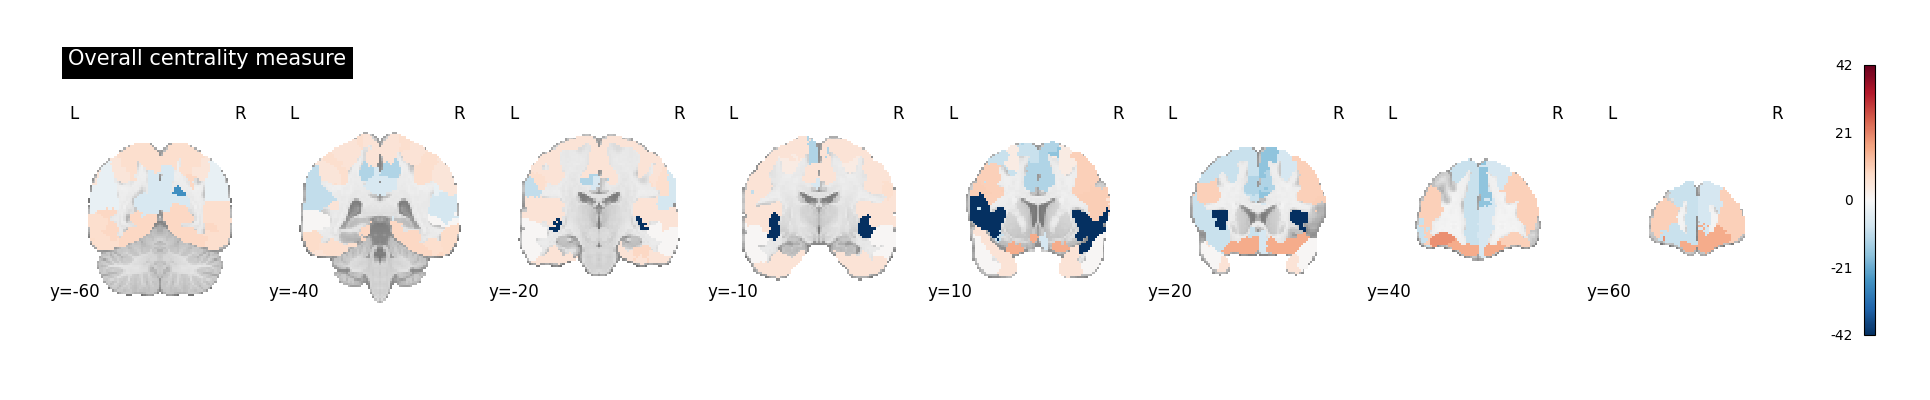

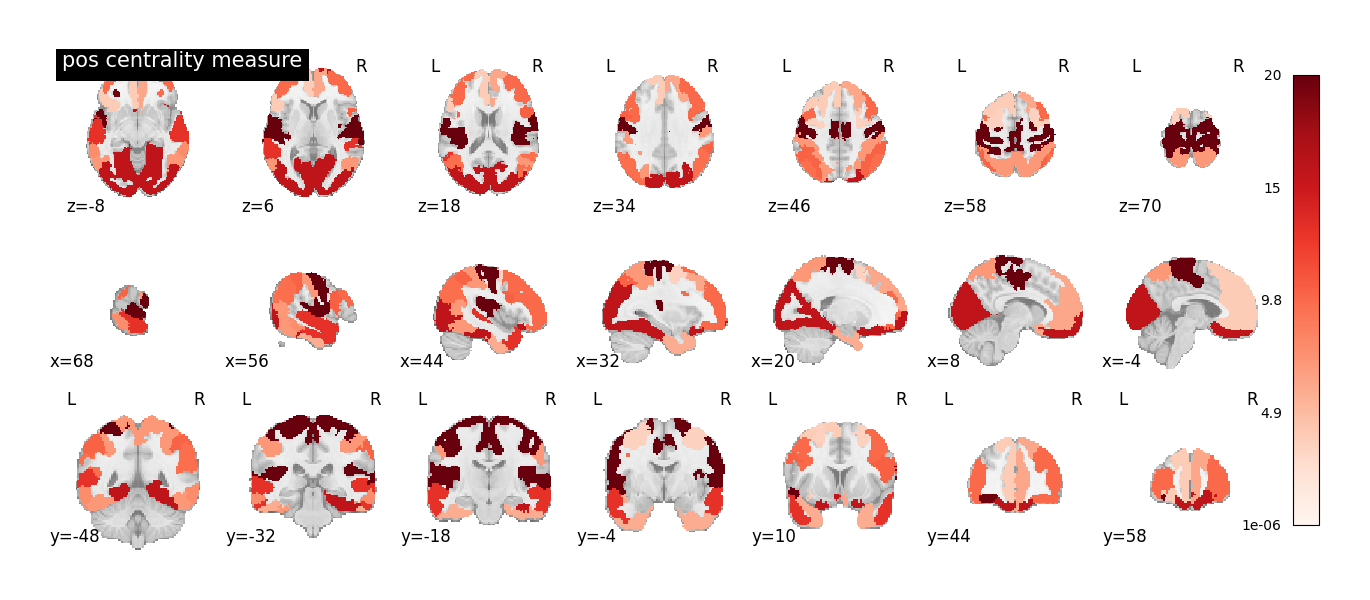

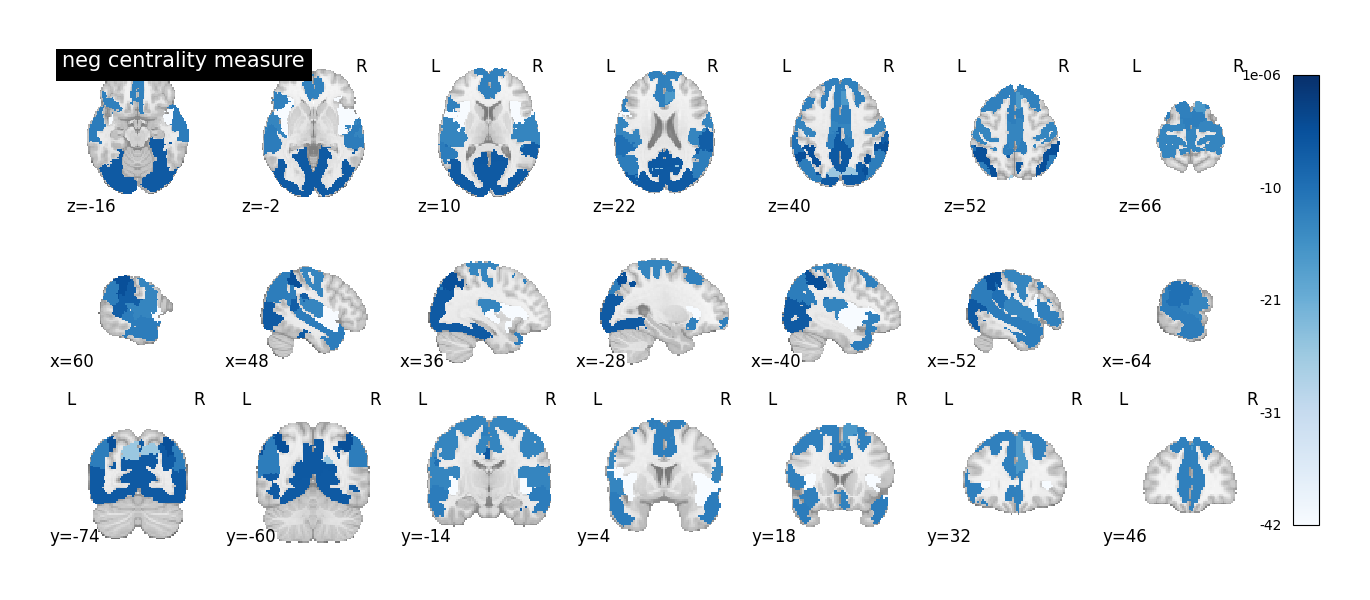

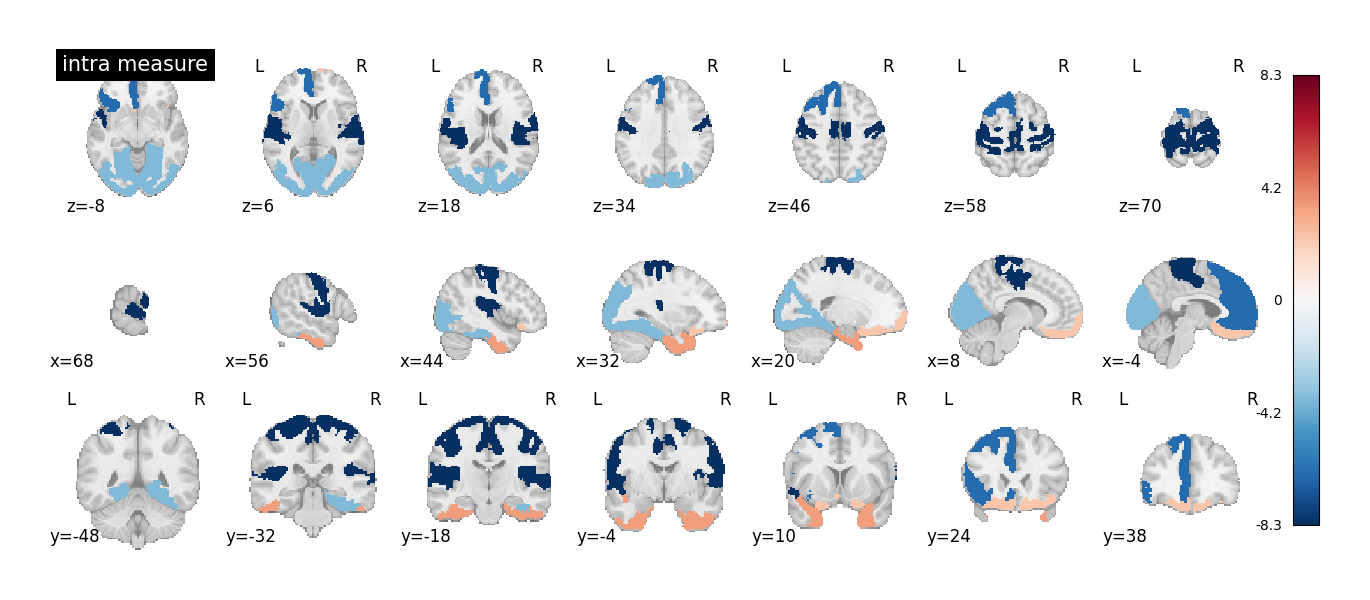

In [18]:
import numpy as np
# from pycct import cct
from scipy.stats import combine_pvalues
from itertools import combinations_with_replacement
from statsmodels.stats.multitest import multipletests, fdrcorrection
from nilearn.connectome import vec_to_sym_matrix


anatomical_networks = np.unique(anatomical_labels)
blocks = list(combinations_with_replacement(anatomical_networks, 2))

final_blocklevel_results = {}

blocked_pvalues = MatrixResult(p_values, anatomical_atlas).get_macro_matrix(agg_func=multivariate_blocks)
blocked_matrices = MatrixResult(haufe_matrices, anatomical_atlas).get_macro_matrix(agg_func=multivariate_blocks)

results = pd.DataFrame(index=anatomical_networks, columns=anatomical_networks, dtype=float)
tmp_results = []
zstat = []
for block_a, block_b in blocks:

    pvalues = blocked_pvalues.loc[block_a, block_b].copy().ravel()
    differences = blocked_matrices.loc[block_a, block_b].copy().ravel()

    # result = cct(pvalues)
    # result = combine_pvalues(pvalues, method='fisher', weights=weights)
    result = signed_stouffer(pvalues, differences)
    pvalue = result.pvalue
    tmp_results.append(pvalue)
    stat = result.statistic
    zstat.append(stat)


# correction for multiple comparisons
result_cor = multipletests(tmp_results, method='holm')[1]

for block_idx, (block_a, block_b) in enumerate(blocks):
    results.loc[block_a, block_b] = result_cor[block_idx]
    results.loc[block_b, block_a] = result_cor[block_idx]

significance_mask = np.where(results.values < 0.05, True, False)

tmp_mat_thresholded = np.where(p_values, haufe_matrices, 0)

block_thresholded_mat = MatrixResult(tmp_mat_thresholded, atlas=anatomical_atlas).get_macro_matrix(lambda block: (block.mean(),))
block_thresholded_mat = block_thresholded_mat.where(significance_mask, 0)

result_to_plot = pd.DataFrame(to_matrix(zstat), 
                                index=anatomical_networks, 
                                columns=anatomical_networks)
result_to_plot = result_to_plot.where(significance_mask, 0)

matrix_to_chord(
    result_to_plot.values,
    anatomical_atlas,
    percentile=None,
    diverging=True,
    positive_only=False
)

pos_centrality, neg_centrality = degree_centrality(block_thresholded_mat, weighted=True)
pos_results_vec = np.zeros(len(anatomical_labels))
neg_results_vec = np.zeros(len(anatomical_labels))
for idx, label in enumerate(anatomical_labels_int):
    pos_results_vec[idx] = pos_centrality[label]
    neg_results_vec[idx] = neg_centrality[label]

intra_results_vec = np.zeros(len(anatomical_labels))
for idx, label in enumerate(anatomical_labels):
    intra_results_vec[idx] = block_thresholded_mat.loc[label, label]

result_to_plot = pd.DataFrame(to_matrix(zstat), 
                                index=anatomical_networks, 
                                columns=anatomical_networks)
result_to_plot = result_to_plot.where(significance_mask, 0)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
g = sns.heatmap(
    result_to_plot,
    center=0,
    cmap='RdBu_r',
    ax=ax,
    square=True,
    cbar_kws={'shrink': 0.4},
    annot=False,
    linewidth=0.2
)

g.set_xticklabels(g.get_xticklabels(), rotation=45, fontsize=10, ha='right')
ax.set_title(f"Connectivity measure")
plt.show()

overall_centrality = pos_results_vec + neg_results_vec

overall_centrality_results = masker.inverse_transform(overall_centrality)

plot_stat_map(
    overall_centrality_results, 
    display_mode='mosaic', cmap='RdBu_r', 
    cut_coords=10,      
    title=f"Overall centrality measure", symmetric_cbar=True)

plot_stat_map(
    overall_centrality_results, 
    display_mode='x', cmap='RdBu_r', 
    cut_coords=(-60,-40,-20,-10,10,20,40,60),      
    title=f"Overall centrality measure", symmetric_cbar=True)
plot_stat_map(
    overall_centrality_results, 
    display_mode='y', cmap='RdBu_r', 
    cut_coords=(-60,-40,-20,-10,10,20,40,60),      
    title=f"Overall centrality measure", symmetric_cbar=True)
overall_centrality_results.to_filename(f"tmp_overall_centrality.nii.gz")

pos_projected_results = masker.inverse_transform(pos_results_vec)
neg_projected_results = masker.inverse_transform(neg_results_vec)
intra_projected_results = masker.inverse_transform(intra_results_vec)

plot_stat_map(pos_projected_results, display_mode='mosaic', cmap='Reds', 
                title=f"pos centrality measure", symmetric_cbar=False)
plot_stat_map(neg_projected_results, display_mode='mosaic', cmap='Blues', 
                title=f"neg centrality measure", symmetric_cbar=False)
plot_stat_map(intra_projected_results, display_mode='mosaic', cmap='RdBu_r', 
                title=f"intra measure", symmetric_cbar=True)
intra_projected_results.to_filename(f"tmp_intra_projection_{classes[0]}_{classes[1]}.nii.gz")

plt.show()